In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.pyplot import figure
from sklearn.metrics import f1_score, recall_score, precision_score
import numpy as np

In [2]:
def calculate_f1_delta_t(data_frame, no_sensors, start_time, max_delta, step_size):
    """
    :param data_frame: Complete Dataframe
    :param no_sensors: Number of Sensors in Dataframe
    :param start_time: Start point. Value from time column
    :param max_delta: Number of samples. max_time = (no_samples * (time between two samples))
    :param step_size: It is the number of samples added to current time_delta to get next time_delta
    :return:
    """
    index_start = data_frame.index[data_frame['ID'] == float(start_time)].to_list()[0]
    subset = data_frame.loc[index_start:(index_start + max_delta), :]
    labels_pred = subset.iloc[:, (4 * no_sensors) + 2:(5 * no_sensors) + 2]
    labels_true = subset.iloc[:, (5 * no_sensors) + 2]

    number_evalutation_sequences = round(max_delta / step_size)
    result_f1_score = np.zeros((number_evalutation_sequences, no_sensors + 1))

    for sensor in range(no_sensors):
        for iteration in range(1, number_evalutation_sequences - 1):
            anomaly_true = labels_true.iloc[0: (iteration * step_size)].values
            anomaly_pred = labels_pred.iloc[0: (iteration * step_size), sensor].values
            result_f1 = f1_score(anomaly_true, anomaly_pred, average="binary")
            result_f1_score[iteration-1, sensor] = result_f1
            result_f1_score[iteration-1, no_sensors] = iteration*step_size

    column_names_f1_score = ["f1 sensor_"+str(i) for i in range(no_sensors)]
    f1_score_df = pd.DataFrame(data=result_f1_score, columns=column_names_f1_score + ["delta_t"])
    return f1_score_df

In [3]:
def calculate_precision_delta_t(data_frame, no_sensors, start_time, max_delta, step_size):
    """
    :param data_frame: Complete Dataframe
    :param no_sensors: Number of Sensors in Dataframe
    :param start_time: Start point. Value from time column
    :param max_delta: Number of samples. max_time = (no_samples * (time between two samples))
    :param step_size: It is the number of samples added to current time_delta to get next time_delta
    :return:
    """
    index_start = data_frame.index[data_frame['ID'] == float(start_time)].to_list()[0]
    subset = data_frame.loc[index_start:(index_start + max_delta), :]
    labels_pred = subset.iloc[:, (4 * no_sensors) + 2:(5 * no_sensors) + 2]
    labels_true = subset.iloc[:, (5 * no_sensors) + 2]

    number_evalutation_sequences = round(max_delta / step_size)
    result_precision_score = np.zeros((number_evalutation_sequences, no_sensors + 1))

    for sensor in range(no_sensors):
        for iteration in range(1, number_evalutation_sequences - 1):
            anomaly_true = labels_true.iloc[0: (iteration * step_size)].values
            anomaly_pred = labels_pred.iloc[0: (iteration * step_size), sensor].values
            result_precision = precision_score(anomaly_true, anomaly_pred, average="binary")
            result_precision_score[iteration-1, sensor] = result_precision
            result_precision_score[iteration-1, no_sensors] = iteration*step_size

    column_names_precision_score = ["precision sensor_"+str(i) for i in range(no_sensors)]
    precision_score_df = pd.DataFrame(data=result_precision_score, columns=column_names_precision_score + ["delta_t"])
    return precision_score_df

In [4]:
def calculate_recall_delta_t(data_frame, no_sensors, start_time, max_delta, step_size):
    """
    :param data_frame: Complete Dataframe
    :param no_sensors: Number of Sensors in Dataframe
    :param start_time: Start point. Value from time column
    :param max_delta: Number of samples. max_time = (no_samples * (time between two samples))
    :param step_size: It is the number of samples added to current time_delta to get next time_delta
    :return:
    """
    index_start = data_frame.index[data_frame['ID'] == float(start_time)].to_list()[0]
    subset = data_frame.loc[index_start:(index_start + max_delta), :]
    labels_pred = subset.iloc[:, (4 * no_sensors) + 2:(5 * no_sensors) + 2]
    labels_true = subset.iloc[:, (5 * no_sensors) + 2]

    number_evalutation_sequences = round(max_delta / step_size)
    result_recall_score = np.zeros((number_evalutation_sequences, no_sensors + 1))

    for sensor in range(no_sensors):
        for iteration in range(1, number_evalutation_sequences - 1):
            anomaly_true = labels_true.iloc[0: (iteration * step_size)].values
            anomaly_pred = labels_pred.iloc[0: (iteration * step_size), sensor].values
            result_recall = recall_score(anomaly_true, anomaly_pred, average="binary")
            result_recall_score[iteration-1, sensor] = result_recall
            result_recall_score[iteration-1, no_sensors] = iteration*step_size

    column_names_recall_score = ["recall sensor_"+str(i) for i in range(no_sensors)]
    recall_score_df = pd.DataFrame(data=result_recall_score, columns=column_names_recall_score + ["delta_t"])
    return recall_score_df

In [114]:
def visualise_metric(results, title):
    fig, axes = plt.subplots(results.shape[1]-1, 1, figsize=(10,20),constrained_layout=False)
    ax = axes.ravel()
    t = results.loc[:,"delta_t"]
    columns = results.columns
    for i in range(results.shape[1]-1): 

        # Predicted mu
        sns.lineplot(data=results, 
                     x=t, 
                     y=columns[i], 
                     ax=ax[i],
                     linewidth=1,
                     color="black")
        ax[i].set_xlabel("delta t [in samples]")
        ax[i].set_ylim(0, 1) 
        #ax[i].set_xlim(0, 200) 
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.suptitle(title, fontsize=16)

## Change of Degeneration Level

In [67]:
start_phase_1 = 24683
start_phase_2 = 38966

## F1 Score: Beginn Phase 2

In [68]:
all_data = pd.read_csv("../../files/prediction/MLE/cpps_new_2sigma.csv", sep=";")

In [111]:
f1_score_result =calculate_f1_delta_t(all_data, 10, start_phase_2, 5000, 100)

In [112]:
f1_score_result.head()

,f1 sensor_0,f1 sensor_1,f1 sensor_2,f1 sensor_3,f1 sensor_4,f1 sensor_5,f1 sensor_6,f1 sensor_7,f1 sensor_8,f1 sensor_9,delta_t
0,0.518519,0.529412,0.529412,0.473282,0.461538,0.461538,0.507463,0.473282,0.347107,0.581560,100.0
1,0.496241,0.501873,0.449612,0.473282,0.467433,0.425197,0.473282,0.400000,0.400000,0.550725,200.0
2,0.473282,0.500000,0.441558,0.445596,0.484848,0.412698,0.441558,0.382749,0.408488,0.522167,300.0
3,0.464491,0.523985,0.446602,0.458574,0.487713,0.406375,0.434442,0.353909,0.440546,0.501873,400.0
4,0.487141,0.520710,0.442368,0.461538,0.480243,0.410175,0.461538,0.384491,0.461538,0.514116,500.0


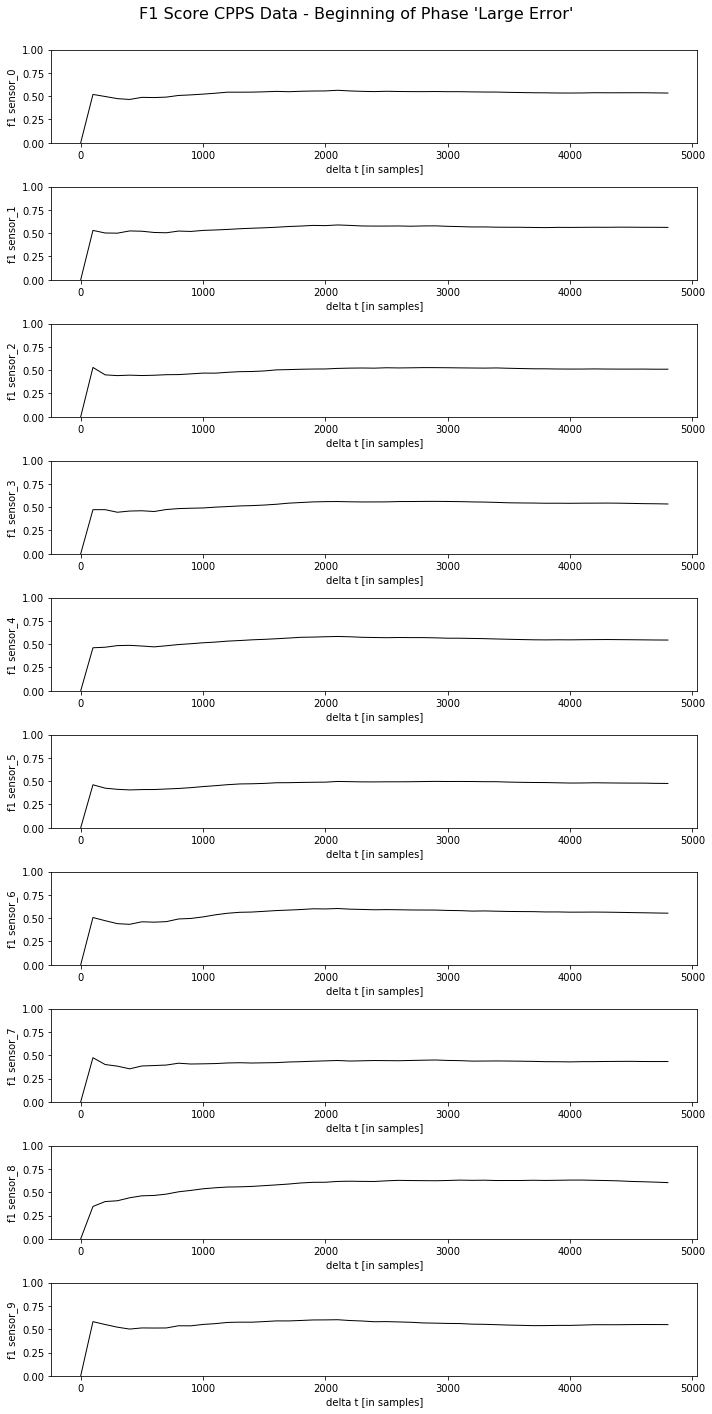

In [115]:
title = "F1 Score CPPS Data - Beginning of Phase 'Large Error'"
visualise_metric(f1_score_result, title)
plt.savefig("./f1_score_cpps_data.png")
plt.show()

## Recall Score: Beginn Phase 2

In [11]:
all_data = pd.read_csv("../../files/prediction/MLE/cpps_new_2sigma.csv", sep=";")

In [12]:
recall_score_result =calculate_recall_delta_t(all_data, 10, start_phase_2, 1000, 5)

In [13]:
recall_score_result.head()

,recall sensor_0,recall sensor_1,recall sensor_2,recall sensor_3,recall sensor_4,recall sensor_5,recall sensor_6,recall sensor_7,recall sensor_8,recall sensor_9,delta_t
0,0.40,0.400000,0.400000,0.400000,0.600000,0.40,0.200000,0.200000,0.20,0.20,5.0
1,0.40,0.300000,0.600000,0.500000,0.500000,0.40,0.200000,0.200000,0.30,0.40,10.0
2,0.40,0.333333,0.466667,0.333333,0.333333,0.40,0.266667,0.266667,0.20,0.40,15.0
3,0.45,0.400000,0.400000,0.250000,0.300000,0.40,0.400000,0.300000,0.25,0.45,20.0
4,0.40,0.400000,0.400000,0.280000,0.280000,0.36,0.440000,0.400000,0.28,0.48,25.0


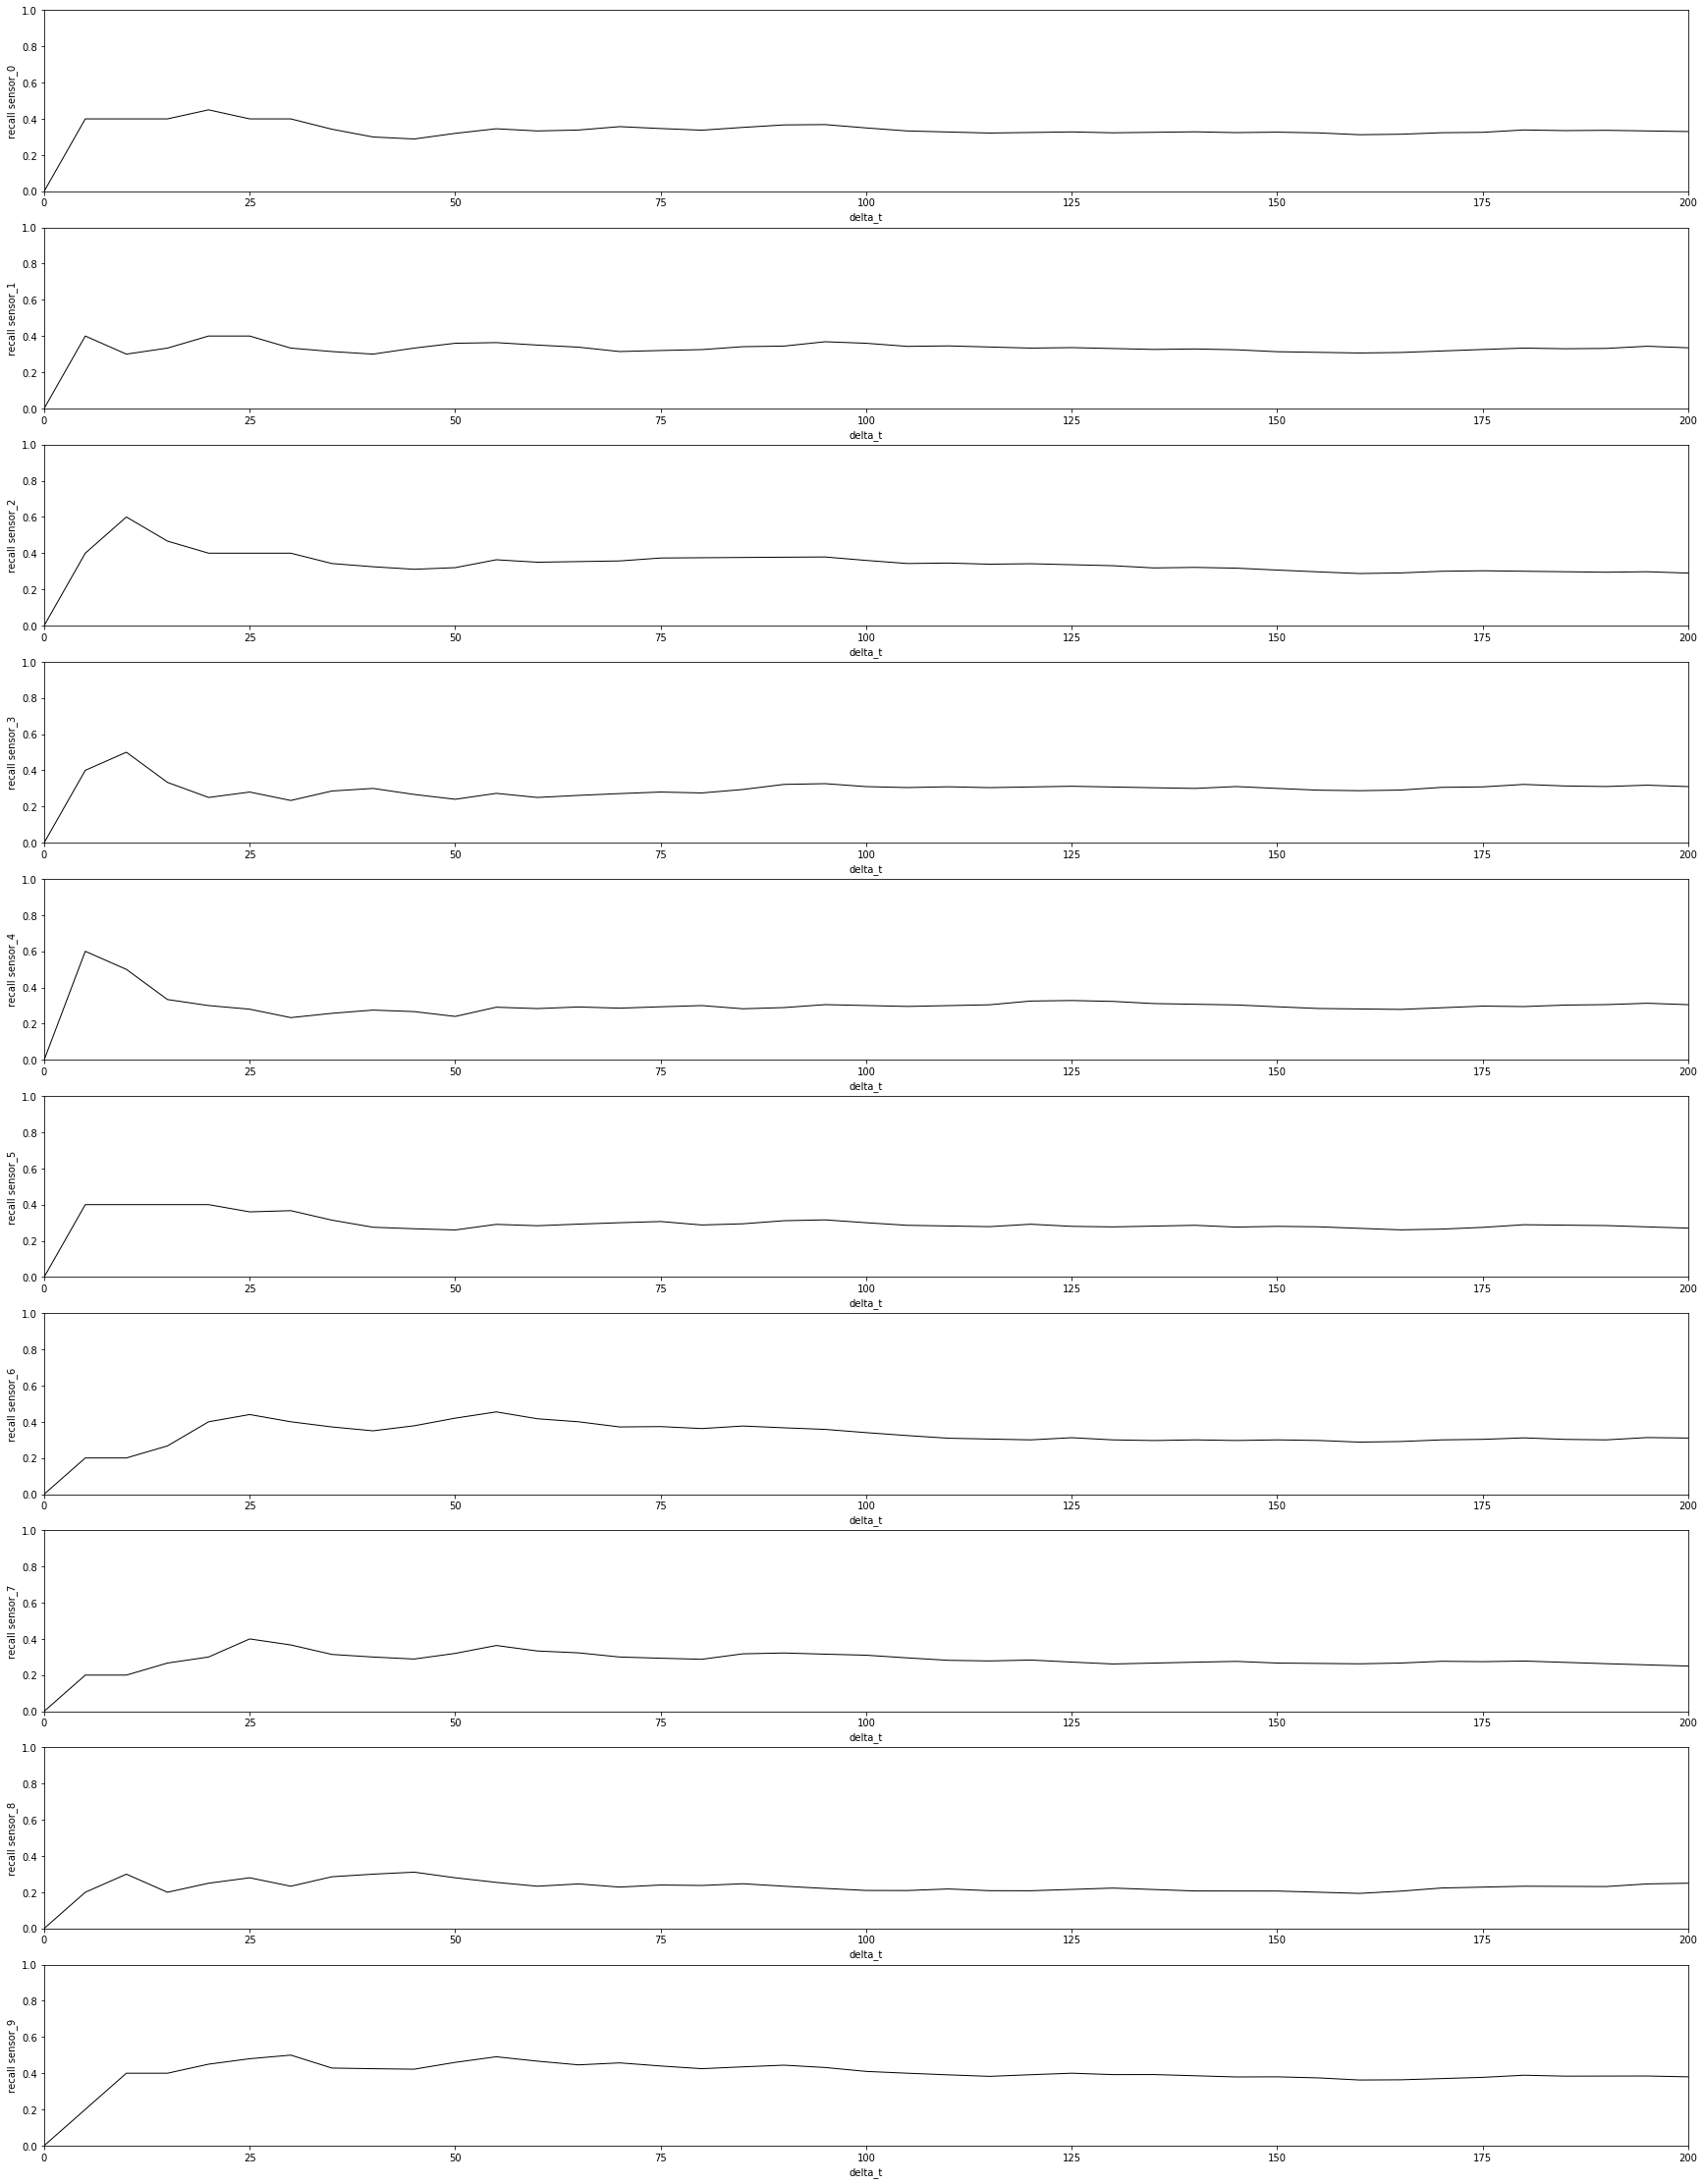

In [14]:
visualise_metric(recall_score_result)
plt.show()

## Precision Score: Beginn Phase 2
Is 1 for every period, due to FP (true label is always 1 --> FP = 0) <br>

In [15]:
all_data = pd.read_csv("../../files/prediction/MLE/cpps_new_2sigma.csv", sep=";")

In [16]:
precision_score_result =calculate_precision_delta_t(all_data, 10, start_phase_2, 1000, 5)

In [17]:
precision_score_result.head()

,precision sensor_0,precision sensor_1,precision sensor_2,precision sensor_3,precision sensor_4,precision sensor_5,precision sensor_6,precision sensor_7,precision sensor_8,precision sensor_9,delta_t
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,10.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,15.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,20.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,25.0


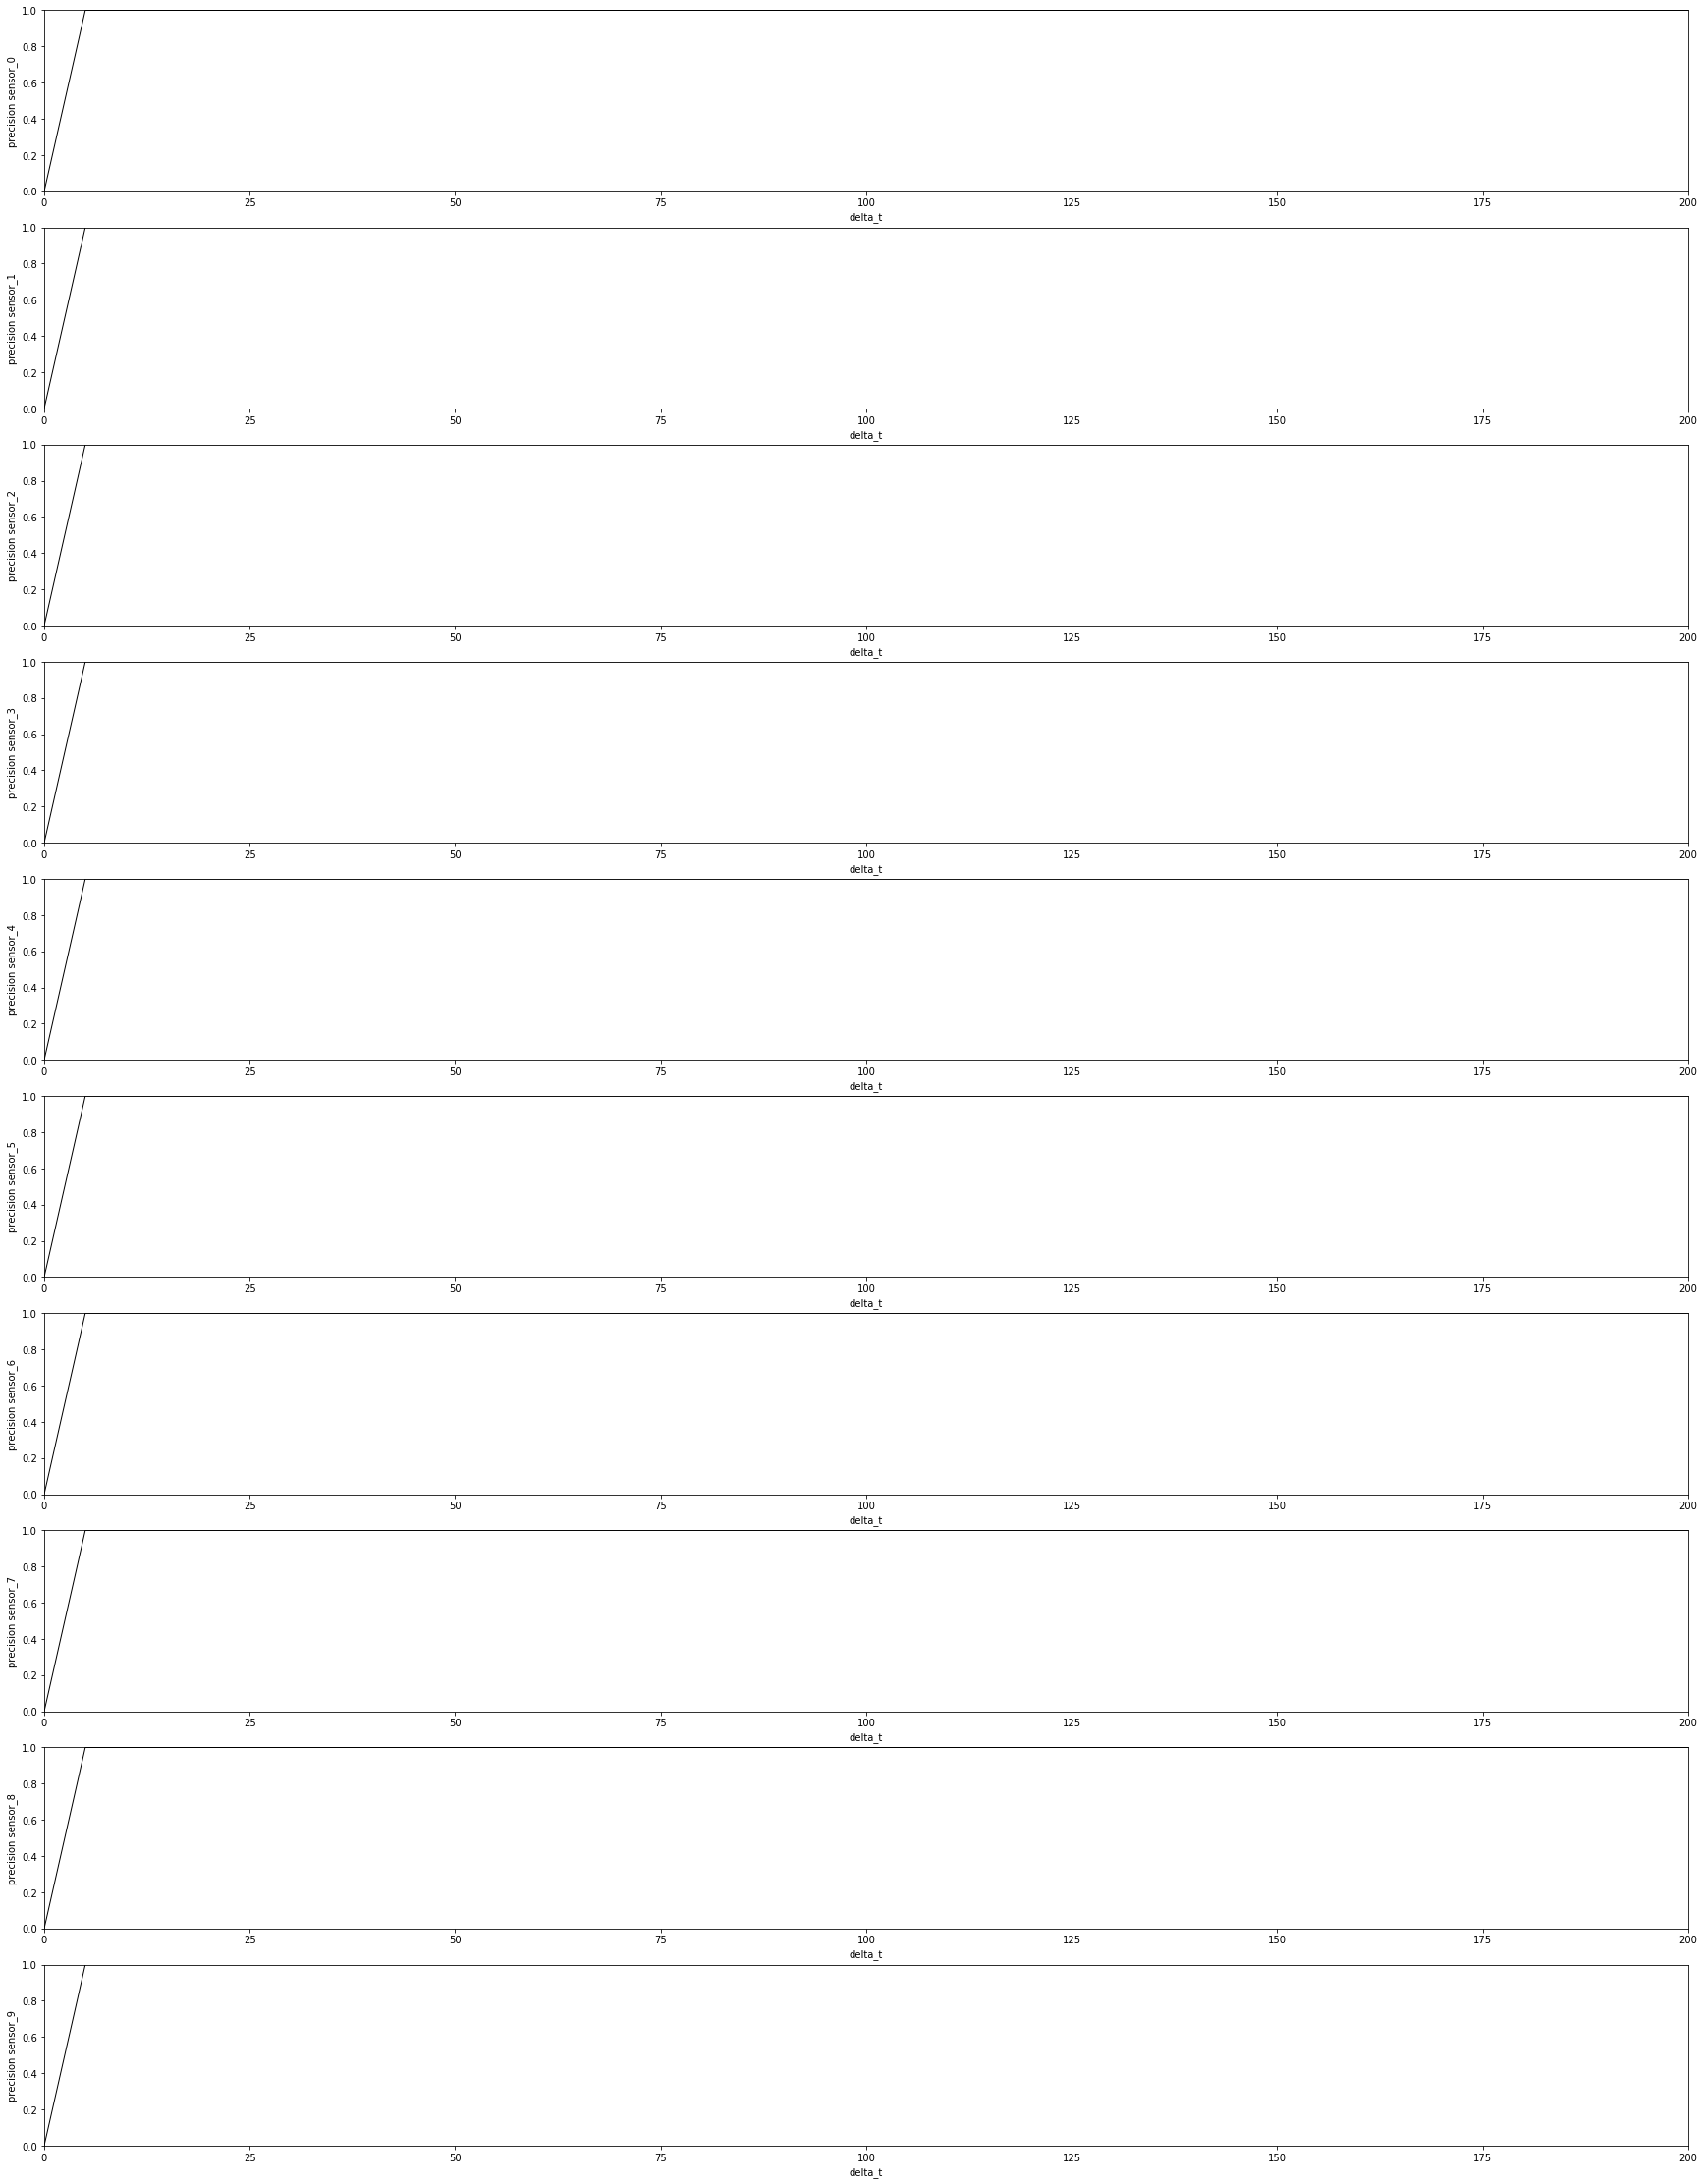

In [18]:
visualise_metric(precision_score_result)
plt.show()

## Phase 0: 
Neither precision nor recall makes sense in this phase, because non of them calculates the TN. Both contain TP in the numerator, leading to always 0

In [50]:
all_data = pd.read_csv("../../files/prediction/MLE/cpps_new_2sigma.csv", sep=";")

In [51]:
recall_score_result =calculate_recall_delta_t(all_data, 10, 10000, 10000, 1000)

In [52]:
recall_score_result.head()

,recall sensor_0,recall sensor_1,recall sensor_2,recall sensor_3,recall sensor_4,recall sensor_5,recall sensor_6,recall sensor_7,recall sensor_8,recall sensor_9,delta_t
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3000.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4000.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5000.0


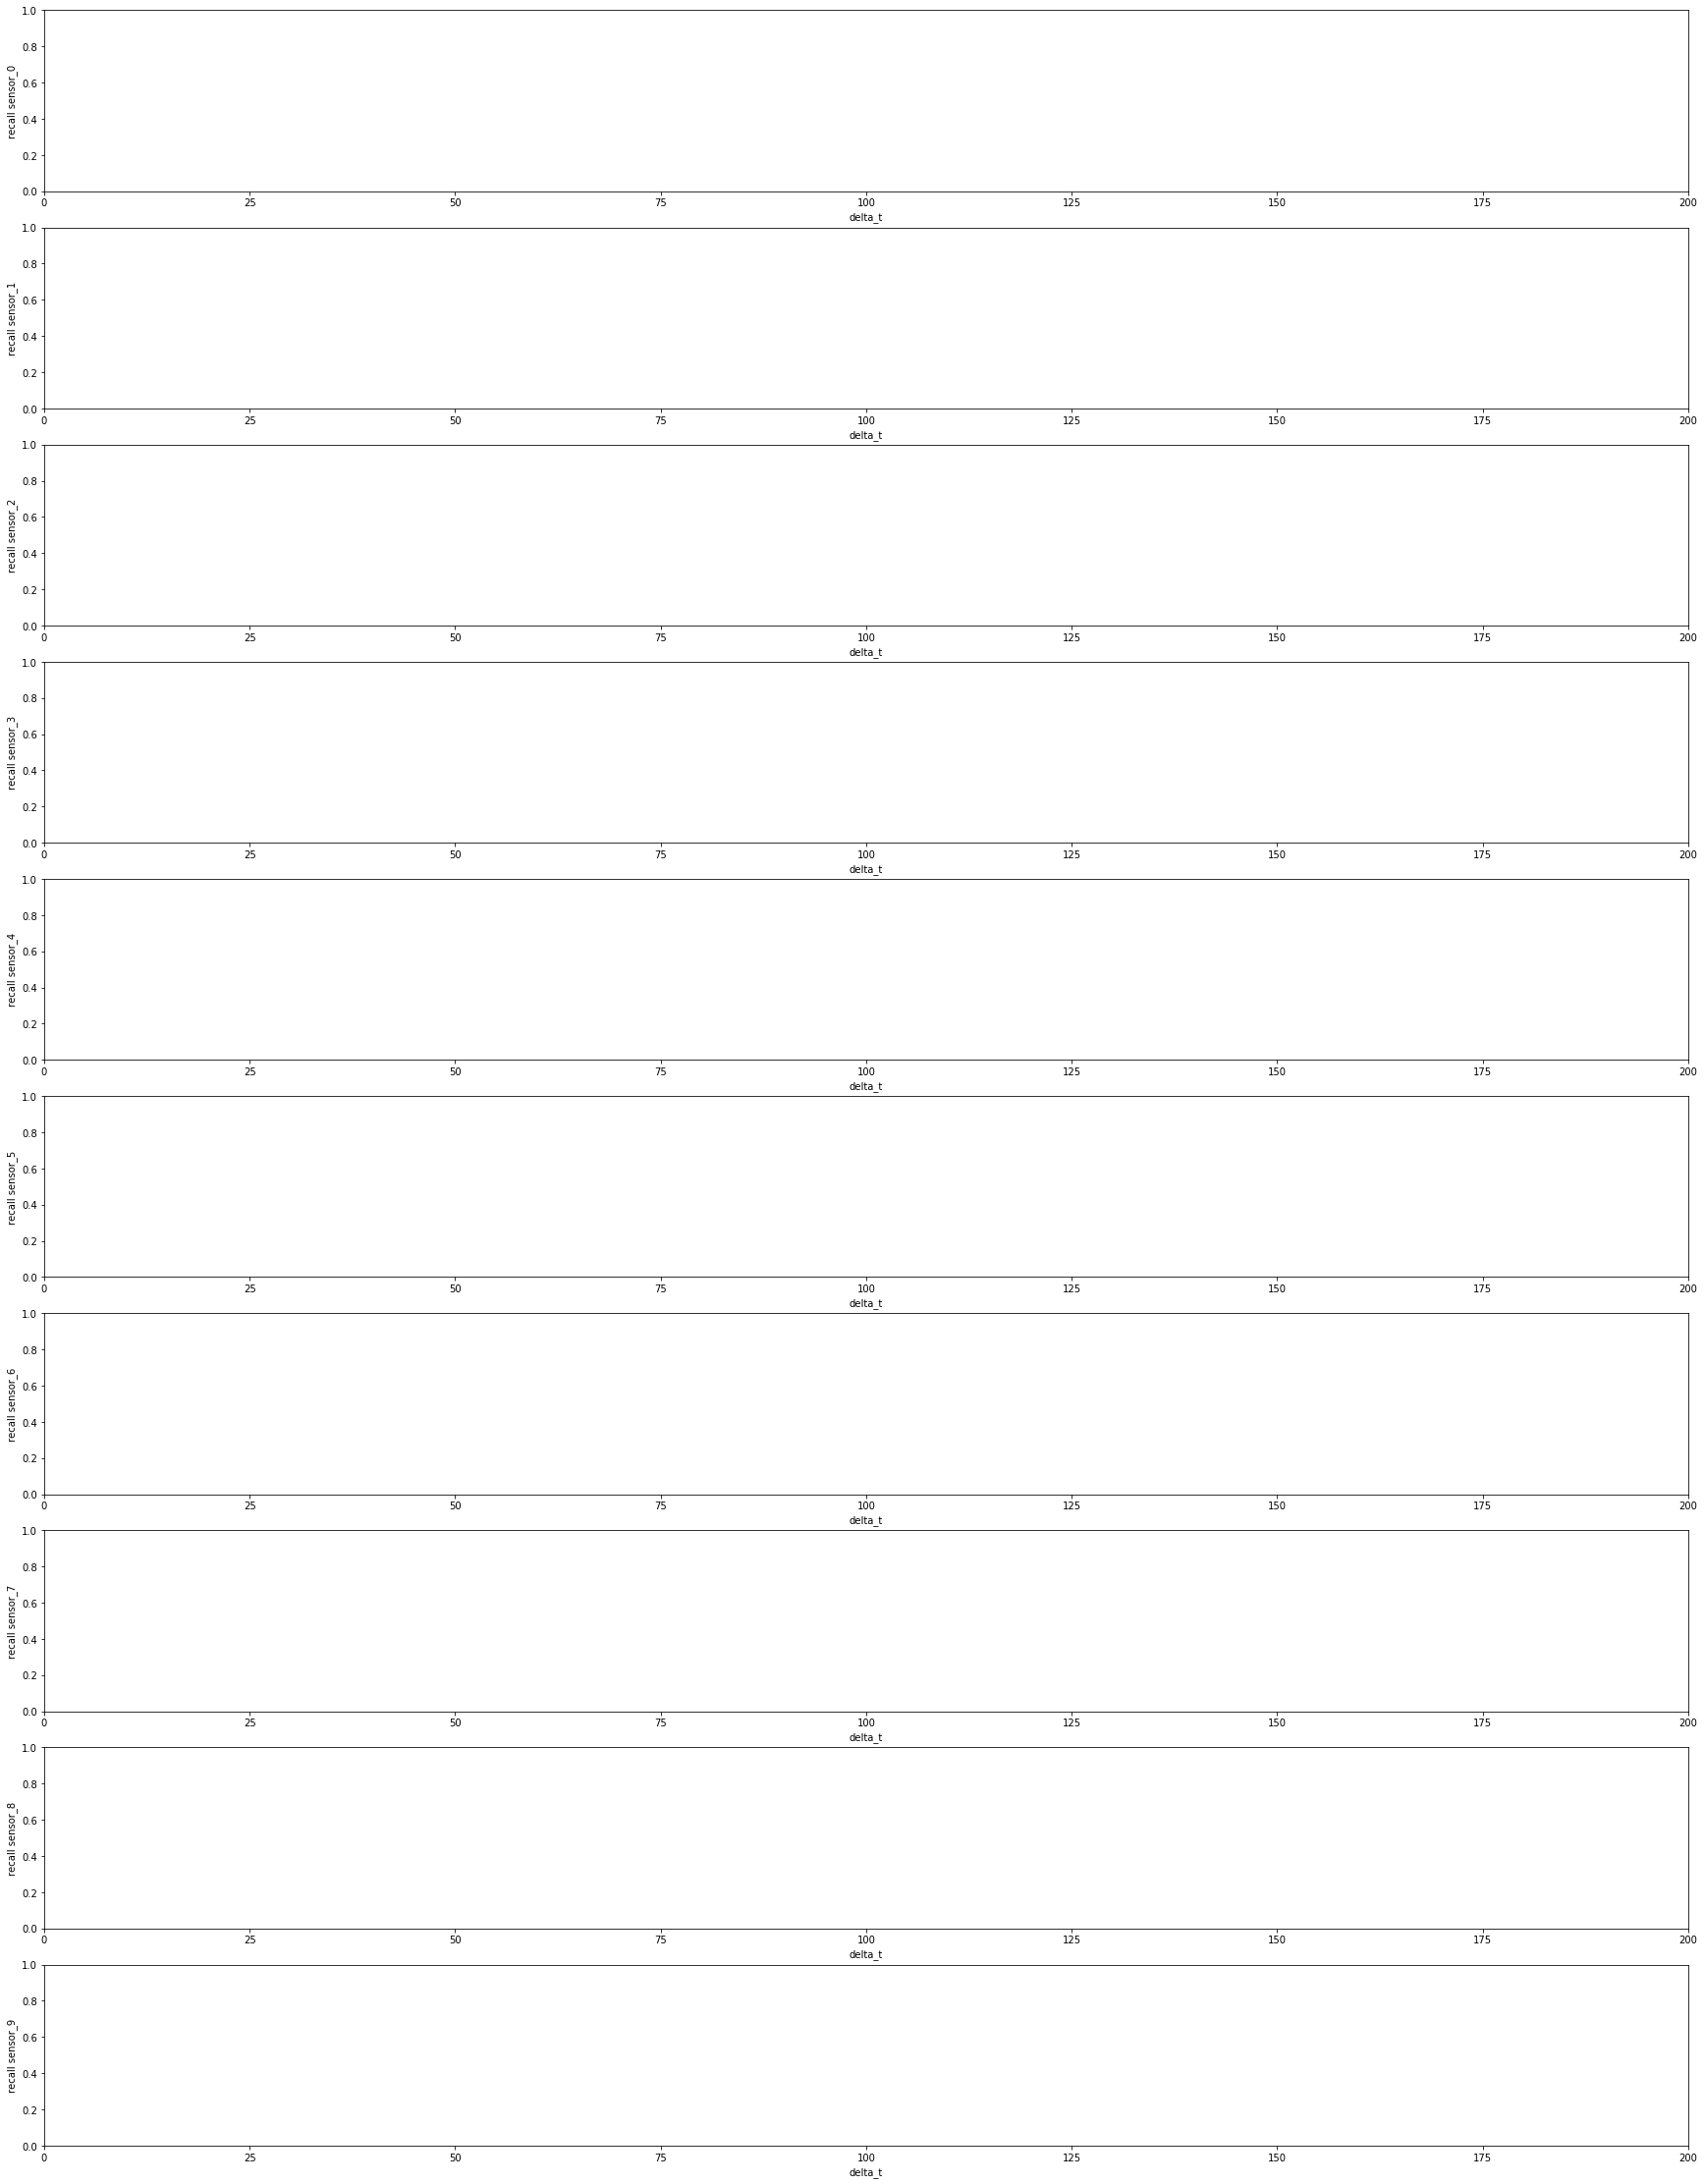

In [53]:
visualise_metric(recall_score_result)
plt.show()